In [3]:
import numpy as np
import pandas as pd


X = pd.DataFrame(pd.read_pickle('data/mnist_data.pkl'))
y = pd.read_pickle('data/mnist_target.pkl')
y = y.astype(np.uint8)

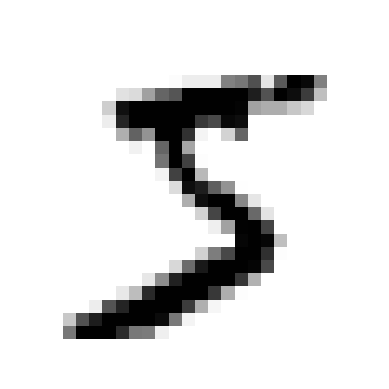

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt


some_digit = X.loc[0].values
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
# 创建一个测试集
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 训练二元分类器

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [11]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

sgd_clf = Pipeline([
    # ('standard', StandardScaler()),
    # ('pca', PCA(n_components=0.95)),
    ('sgd', SGDClassifier(random_state=42))])


sgd_clf.fit(X_train, y_train_5)

Pipeline(steps=[('sgd', SGDClassifier(random_state=42))])

In [12]:
sgd_clf.score(X_test,y_test_5)

0.9492

# 性能测量

In [ ]:
# 使用交叉验证测量准确率

# 相比于Scikit-Learn提供cross_val_score（）这一类交叉验证的函数，有时你可能希望自己能控制得多一些

# 每个折叠由StratifiedKFold执行分层抽样（参见第2章）产生，
# 其所包含的各个类的比例符合整体比例。
# 每个迭代会创建一个分类器的副本，用训练集对这个副本进行训练，然后用测试集进行预测。
# 最后计算正确预测的次数，输出正确预测的比率

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)

    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565, and 0.96495

0.9669
0.91625
0.96785


In [ ]:
# K-折交叉验证的意思是将训练集分解成K个折叠（在本例中，为3折），然后每次留其中1个折叠进行预测，剩余的折叠用来训练

from sklearn.model_selection import cross_val_score


cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

                    混淆矩阵                    

In [1]:
import numpy as np
import pandas as pd


X = pd.DataFrame(pd.read_pickle('data/mnist_data.pkl'))
y = pd.read_pickle('data/mnist_target.pkl')
y = y.astype(np.uint8)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

要计算混淆矩阵，需要先有一组预测才能将其与实际目标进行比
较。当然，可以通过测试集来进行预测，但是现在先不要动它（测试集
最好留到项目的最后，准备启动分类器时再使用）。作为替代，可以使
用cross_val_predict（）函数

In [2]:
# cv=3，分成3份，其中循环3次，每次两份用于训练，一份用于预测
# 这意味着对于每个实例都可以得到一个干净的预测（“干净”的意思是模型预测时使用的数据在其训练期间从未见过）
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [3]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_train_5, y_train_pred)

df = pd.DataFrame(c_matrix, columns=('预测器输出假', '预测器输出真'), index=('本来是假', '本来是真'))
df

# 混淆矩阵中的行表示实际类别，列表示预测类别

# 根据下表，第一行分别是真负类、假正类
#         第二行分别是假负类、真正类

,预测器输出假,预测器输出真
本来是假,53892,687
本来是真,1891,3530


混淆矩阵能提供大量信息，但有时你可能希望指标更简洁一些。
正类预测的准确率是一个有意思的指标，它也称为分类器的精度\
TP是真正类的数量（true positive），FP是假正类的数量（false positive）

$$\text{精度}=\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}}$$

$$\text{召回率}=\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}$$

In [5]:
from sklearn.metrics import precision_score, recall_score

# 精度
p_score = precision_score(y_train_5, y_train_pred)  # == 4096 / (4096 + 1522)
print(p_score)

# 召回率
recall_score(y_train_5, y_train_pred)  # == 4096 / (4096 + 1325)

0.8370879772350012


0.6511713705958311

                    精度/召回率权衡                 

要理解这个权衡过程，我们来看看SGDClassifier如何进行分类决策。\
对于每个实例，它会基于决策函数计算出一个分值，如果该值大于阈值，则将该实例判为正类，否则便将其判为负类

In [7]:
# 调用decision_function（）方法，这种方法返回每个实例的分数
# y_scores = sgd_clf.decision_function([some_digit])

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [8]:
# 有了这些分数，可以使用precision_recall_curve（）函数来计算所有可能的阈值的精度和召回率

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

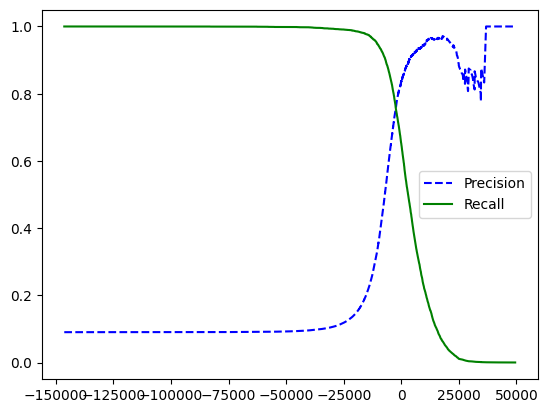

In [11]:
# 最后，使用Matplotlib绘制精度和召回率相对于阈值的函数图
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Text(0, 0.5, 'precision')

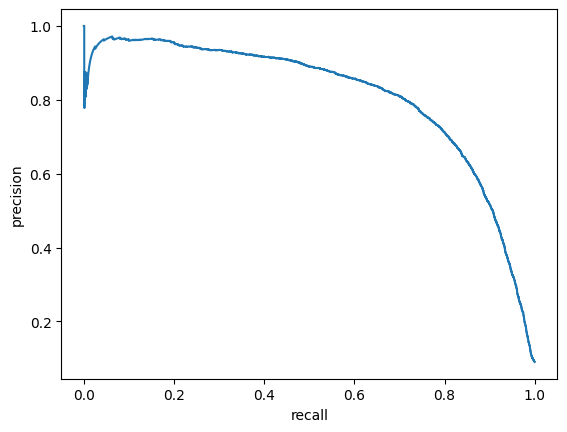

In [13]:
# 另一种找到好的精度/召回率权衡的方法是直接绘制精度和召回率的函数图

plt.plot(recalls, precisions, '-')
plt.xlabel('recall')
plt.ylabel('precision')

In [14]:
# 假设你决定将精度设为90%。查找图发现需要设置8000的阈值。
# 更精确地说，你可以搜索到能提供至少90%精度的最低阈值（np.argmax（）会给你最大值的第一个索引，
# 在这种情况下，它表示第一个True值）

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [15]:
p_score = precision_score(y_train_5, y_train_pred_90)
print(p_score)
recall_score(y_train_5, y_train_pred_90)

0.9000345901072293


0.4799852425751706